In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib
from phd_plots import *
from IPython.display import clear_output

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(784, 64)
        #self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
lr=0.001
opts = [
    [optim.SGD, dict(lr=lr), f"SGD, $\\alpha={{{lr}}}$"],
    [optim.SGD, dict(lr=lr/10), f"SGD, $\\alpha={{{lr/10}}}$"],
    [optim.Adadelta, dict(), "Adadelta"],
    [optim.Adagrad, dict(), f"Adagrad, $\\alpha={{{lr}}}$"],
    [optim.Adam, dict(), "Adam"],
    [optim.RMSprop, dict(), "RMSprop"],
]

if torch.cuda.is_available():
    device = torch.device("cuda")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
    
    
nets = [Net().cuda() for _ in opts] 

optimizers = [o[0](nets[_i].parameters(), **o[1]) for _i, o in enumerate(opts)]
criterions = [nn.CrossEntropyLoss().cuda() for _ in optimizers]


Running on the GPU


In [3]:
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

mnist_data = torchvision.datasets.MNIST(root='./mnist_data', train=True, download=True, transform=transform)
#mnist_data = torch.utils.data.Subset(mnist_data, list(range(1024*8)))
dataloader = torch.utils.data.DataLoader(mnist_data, batch_size=32, shuffle=True, )

In [4]:
loss_data=[]
epoch_loss_data = []

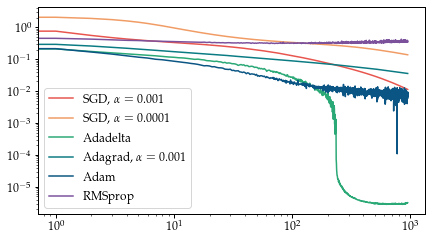

In [5]:
for epoch in tqdm(range(1000)):
    loss_data = []
    for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, labels = data
        
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        [o.zero_grad() for o in optimizers]
        
        outputs = [net(inputs) for net in nets]
        losses = [criterion(outputs[_i], labels) for _i, criterion in enumerate(criterions)]
        [l.backward() for l in losses]
        [o.step() for o in optimizers]
        
        loss_data.append([l.item() for l in losses])
        
    #print(np.average(loss_data, axis=0))
    epoch_loss_data.append(np.average(loss_data, axis=0))
    
    if epoch%50==0:
        loss_data_a = np.array(epoch_loss_data)
        fig, axs = single_wide()
        for o in range(loss_data_a.shape[1]):
            #smooth = 100
            #y = np.convolve(loss_data_a[:,o], np.ones(smooth)/smooth)
            #axs[0].loglog(y[smooth:-smooth], label=opts[o][2])
            axs[0].loglog(loss_data_a[:,o], label=opts[o][2])

        axs[0].legend()
        clear_output(wait=True)
        plt.show()
    
    

NameError: name 'np' is not defined